# 1. keras 模型训练

data: https://www.kaggle.com/datasets/sagnikseal/household-power-consumption

In [1]:
DIRECTORY='./data/'
FILE_NAME='Household_power_consumption.csv'
KERAS_MODEL_FILE_NAME='keras_model.h5'
BATCH_SIZE=32
NUM_STEPS=60  # 考虑输入数据的自然周期 

In [2]:
# !pip install pygwalker
# !pip install tensorflow

In [3]:
import random
import datetime
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.metrics
import pygwalker as pyg
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

import power_util

## 1. 数据导入

In [4]:
file_path = power_util.gen_abspath(DIRECTORY, FILE_NAME)
date_parser = lambda e: datetime.datetime.strptime(e, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(file_path,
                 header=0,
                 sep=',',
                 index_col='datetime',
                 on_bad_lines='warn',
                 parse_dates=['datetime'],
                 date_format='%Y-%m-%d %H:%M:%S',
                 encoding='utf-8')

df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,15.766666
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,15.733334
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,15.633333


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   sub_metering_4         float64
dtypes: float64(8)
memory usage: 142.5 MB


In [6]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
dtype: int64

## 2. 数据预处理

In [7]:
# 本数据集无空值，无需补空
def prepare(df):
    # 使用线性插值补空
    df.interpolate(method='linear', axis=0, inplace=True)
    
    # 无法补空的缺省值，整行删除
    df.dropna(inplace=True)

    return df

In [8]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.089418e+00,1.236871e-01,2.408364e+02,4.618401e+00,1.118474e+00,1.291131e+00,6.448635e+00,9.298722e+00
std,1.054678e+00,1.125933e-01,3.240051e+00,4.433165e+00,6.141460e+00,5.796922e+00,8.433584e+00,9.561278e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+00
50%,6.020000e-01,1.000000e-01,2.410000e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.500000e+00
75%,1.526000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.036667e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248333e+02


In [9]:
# pyg.walk(df)

## 3. 趋势可视化

In [10]:
len(df)

2075259

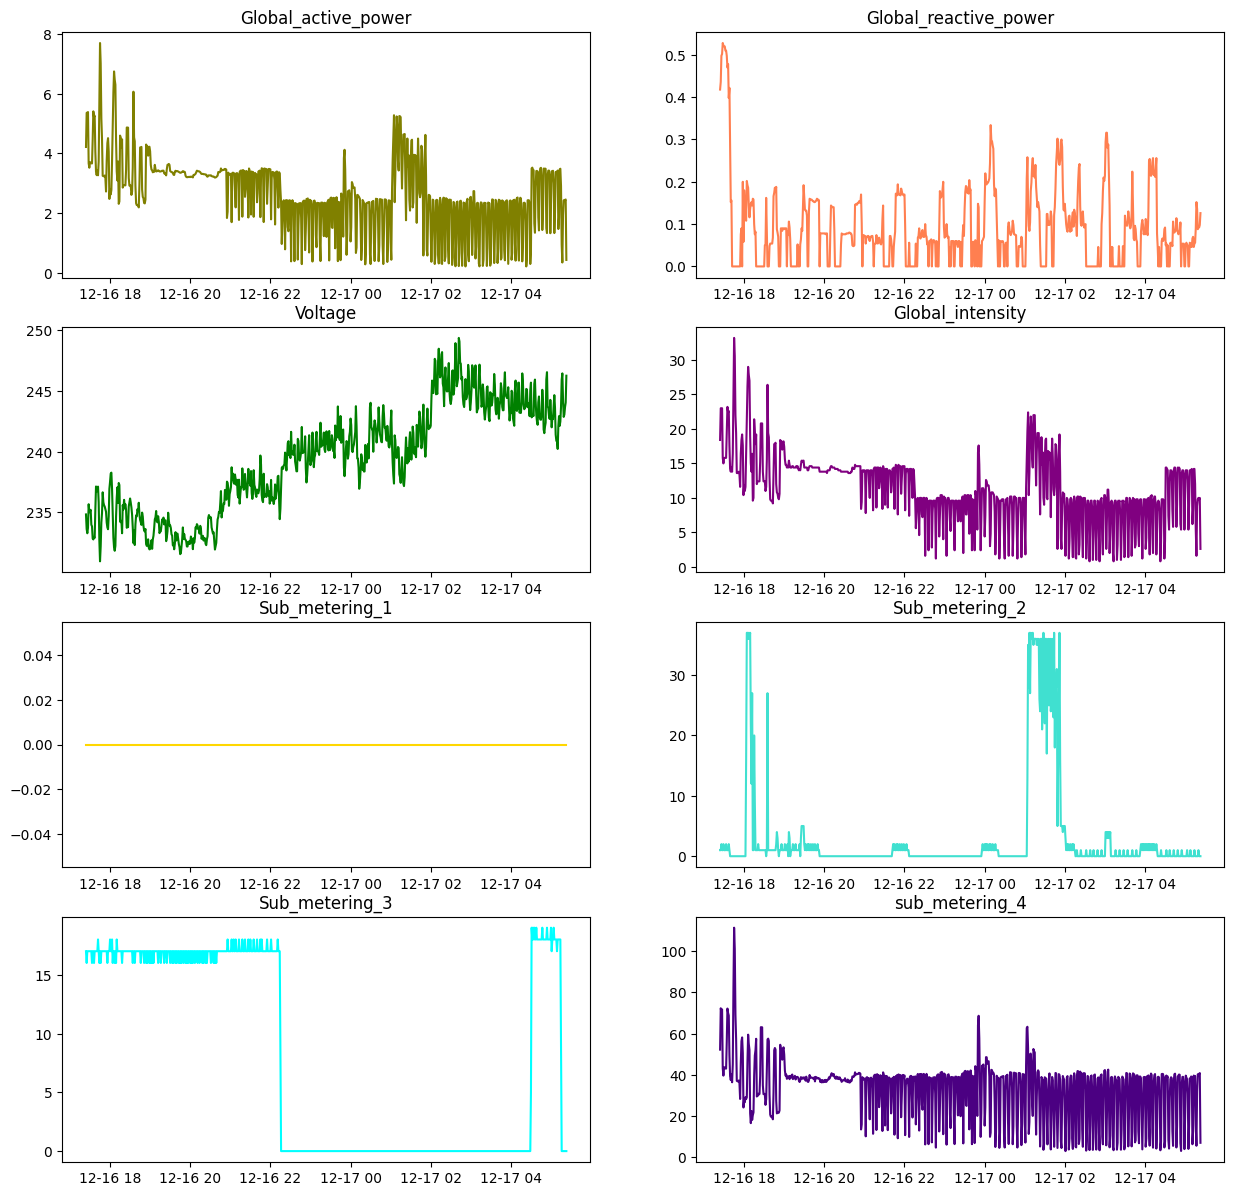

In [11]:
# 头 720 个值
df_graph = df.iloc[:60*12]
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'sub_metering_4']
colors = ['olive', 'coral', 'green', 'purple', 'gold', 'turquoise', 'cyan', 'indigo']
plt.figure(figsize=(15,30))
for i, (col, color) in enumerate(zip(cols, colors)):
    plt.subplot(8, 2, i+1)
    plt.plot(df_graph[col], color=color)
    plt.title(col)

plt.show()

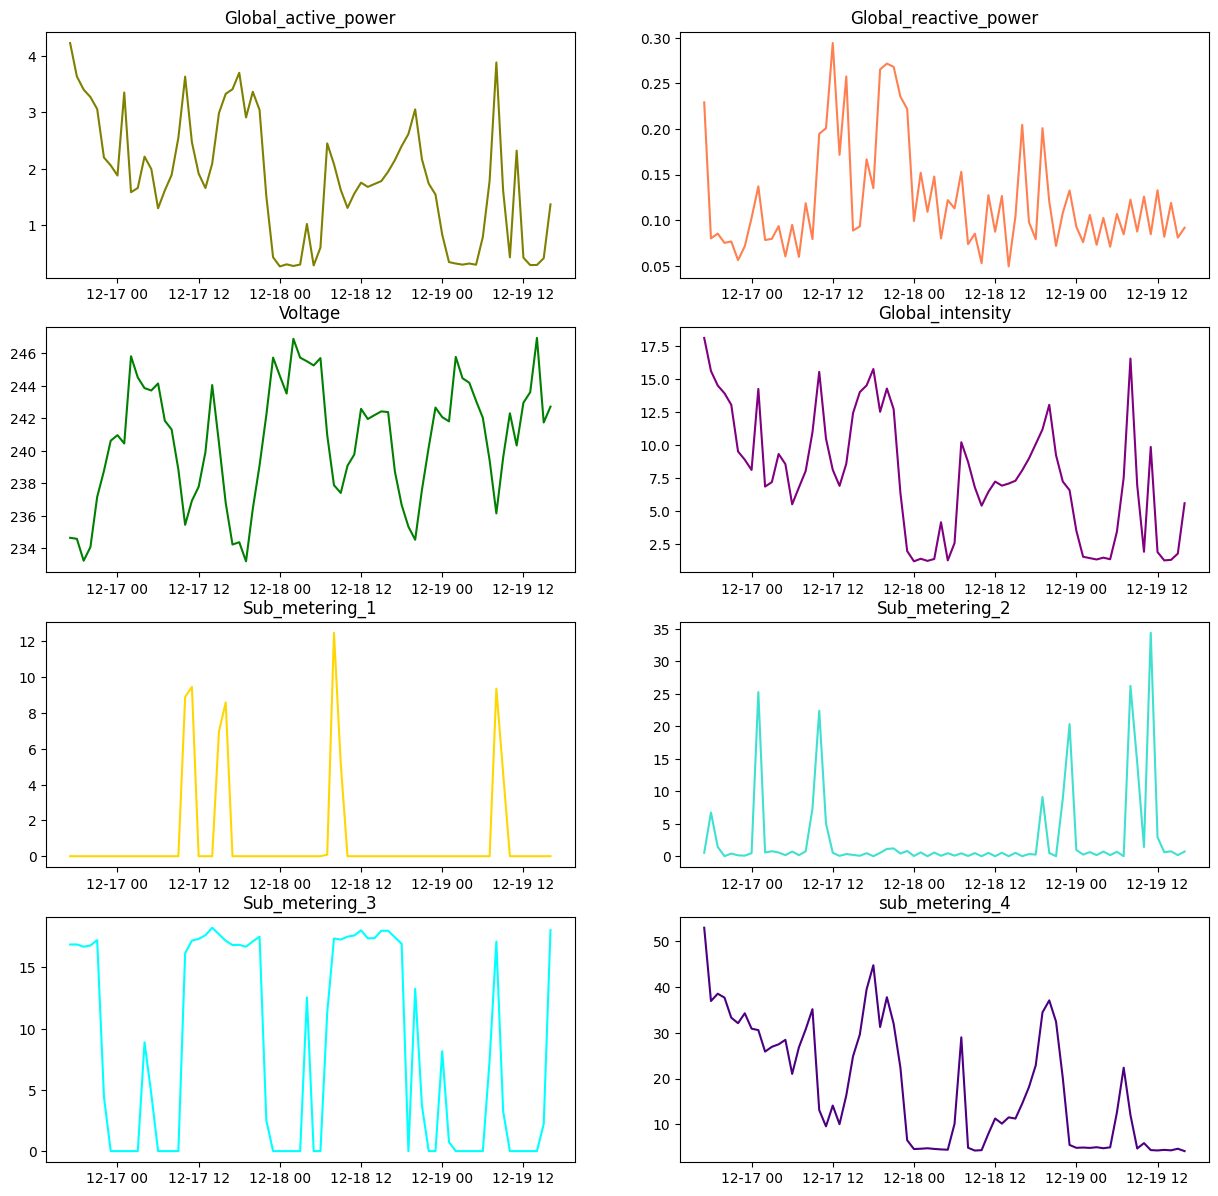

In [12]:
# 小时级重采样，取前3天
n_days = 3

cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'sub_metering_4']
colors = ['olive', 'coral', 'green', 'purple', 'gold', 'turquoise', 'cyan', 'indigo']
plt.figure(figsize=(15,30))
for i, (col, color) in enumerate(zip(cols, colors)):
    plt.subplot(8, 2, i+1)
    plt.plot(df[col].resample('h').mean().iloc[:n_days*24], color=color)
    plt.title(col)

plt.show()

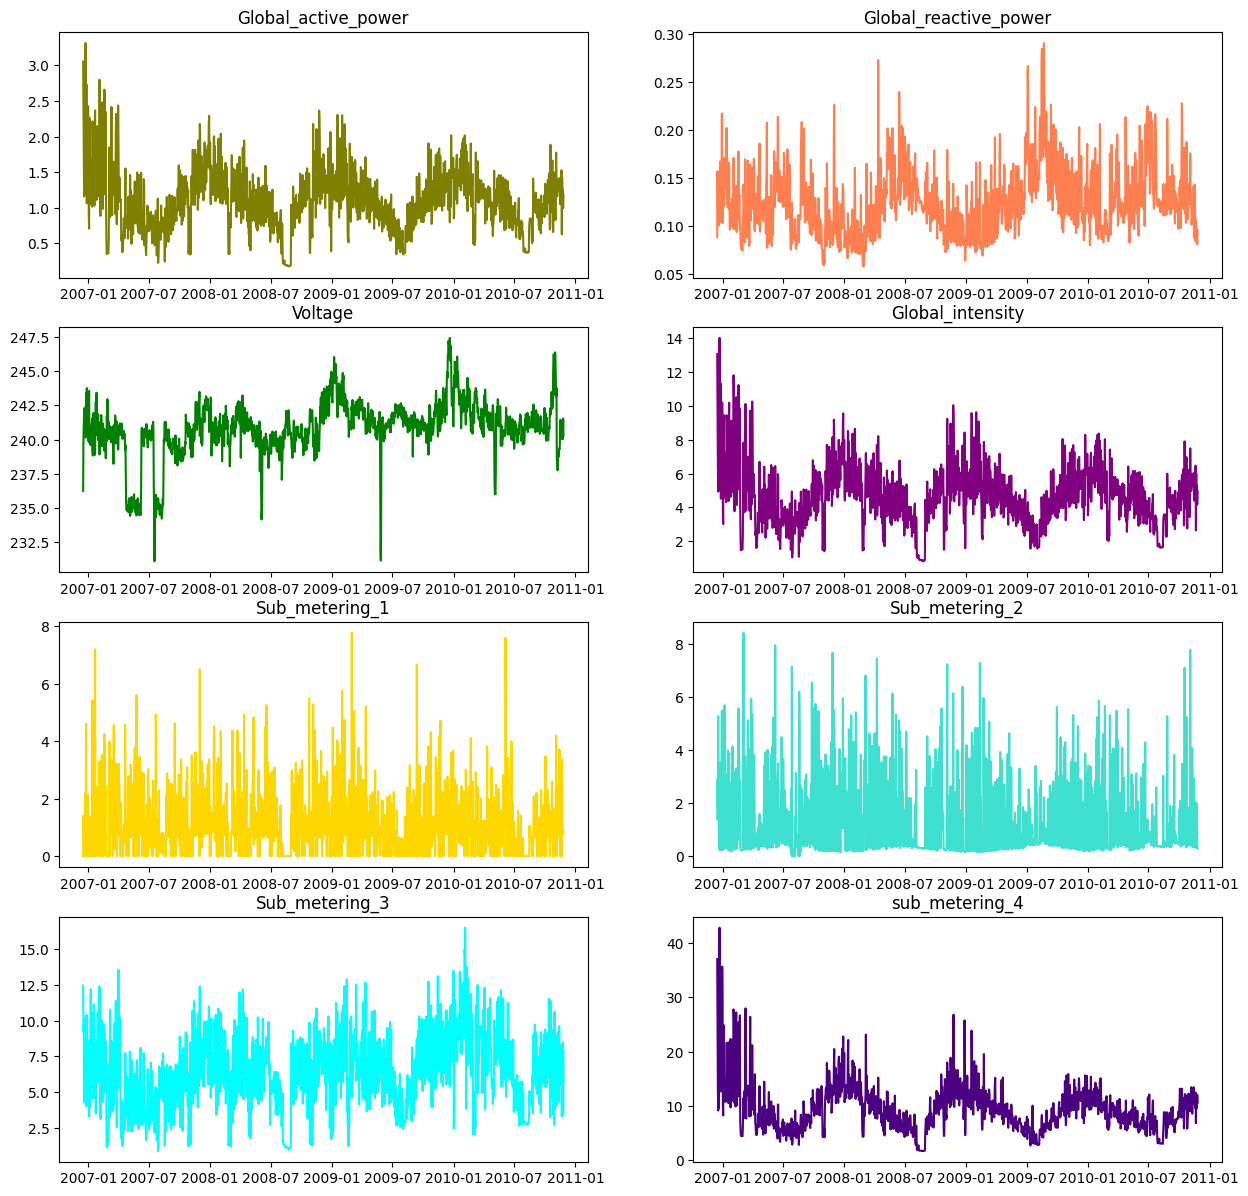

In [13]:
# 天级重采样
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'sub_metering_4']
colors = ['olive', 'coral', 'green', 'purple', 'gold', 'turquoise', 'cyan', 'indigo']
plt.figure(figsize=(15,30))
for i, (col, color) in enumerate(zip(cols, colors)):
    plt.subplot(8, 2, i+1)
    plt.plot(df[col].resample('d').mean(), color=color)
    plt.title(col)

plt.show()

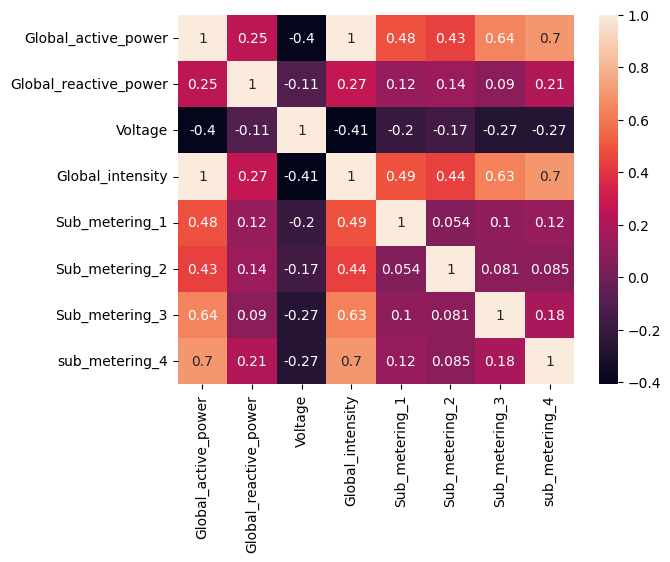

In [14]:
# 计算列与列之间的相关系数
sns.heatmap(df.corr(), annot=True)
plt.show()

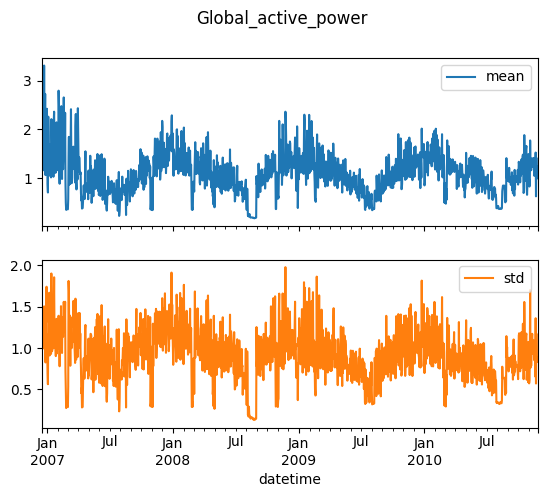

In [15]:
# 均值与标准差的关系
r = df['Global_active_power'].resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_active_power')
plt.show()

## 4. 分割训练集和测试集

In [16]:
# 特征缩放
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(df)

data.shape

(2075259, 8)

In [17]:
# 随机采样策略
def seq_data_iter(corpus, num_steps, use_random):
    # 随机偏移
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 子序列的数量，-1 是给 y label 挪空间
    num_subseqs = (len(corpus) - 1) // num_steps
    # 子序列起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    if use_random:
        random.shuffle(initial_indices)

    # 输入起始索引，返回整个序列
    def data(pos):
        return corpus[pos:pos+num_steps]

    X = np.array([data(i) for i in initial_indices])
    Y = np.array([corpus[i+num_steps] for i in initial_indices])

    return X, Y

In [18]:
# 分割训练集和测试集
train = data[:2000000,]
test = data[2000000:,]

train.shape, test.shape

((2000000, 8), (75259, 8))

In [19]:
X_train, y_train = seq_data_iter(corpus=train,
                                 num_steps=NUM_STEPS,
                                 use_random=True)
X_test, y_test = seq_data_iter(corpus=test,
                               num_steps=NUM_STEPS,
                               use_random=True)

X_train.shape, y_train.shape

((33332, 60, 8), (33332, 8))

## 5. 定义 & 训练网络 

In [20]:
def lstm_model(X, y, num_epochs, batch_size, learning_rate):
    num_steps = X.shape[1]
    feature_num = X.shape[2]
    
    model = keras.models.Sequential()
    # Adding the first layer
    model.add(keras.layers.LSTM(units=32,
                                input_shape=(num_steps, feature_num),
                                return_sequences=True))
    # Adding the second layer
    model.add(keras.layers.LSTM(units=16, return_sequences=True))
    model.add(keras.layers.Dropout(0.2))
    # Adding the third layer
    model.add(keras.layers.LSTM(units=10))
    # Adding the output layer
    model.add(keras.layers.Dense(feature_num))

    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['mean_squared_error'])

    history = model.fit(X, y,
                        validation_split=0.25,
                        epochs=num_epochs,
                        batch_size=batch_size)

    return model, history

In [21]:
model, history = lstm_model(X_train, y_train,
                            num_epochs=15,
                            batch_size=BATCH_SIZE,
                            learning_rate=.001)

2024-05-11 11:15:04.036851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
782/782 [==============================] - 37s 41ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2/15
782/782 [==============================] - 31s 40ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 3/15
782/782 [==============================] - 32s 41ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 4/15
782/782 [==============================] - 31s 40ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/15
782/782 [==============================] - 32s 41ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/15
782/782 [==============================] - 36s 45ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 7/15
782/7

In [22]:
# 保存模型
keras_model_path = power_util.gen_abspath(DIRECTORY, KERAS_MODEL_FILE_NAME)
model.save(keras_model_path)

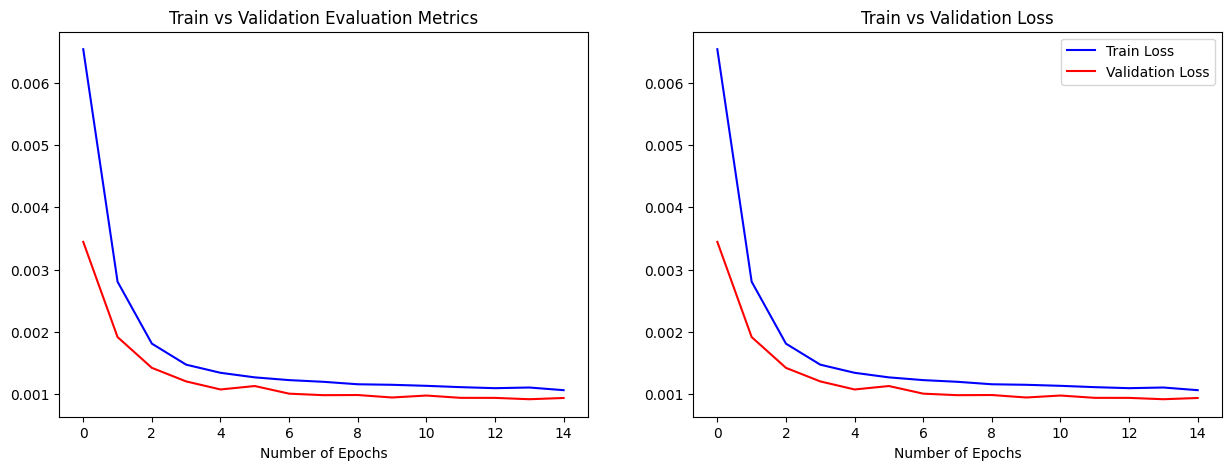

In [23]:
# 训练过程可视化
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history.history['mean_squared_error'], color='blue', label='Train Evaluation')
plt.plot(history.history['val_mean_squared_error'], color='red', label='Validation Evaluation')
plt.title('Train vs Validation Evaluation Metrics')
plt.xlabel('Number of Epochs')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], color='blue', label='Train Loss')
plt.plot(history.history['val_loss'], color='red', label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Number of Epochs')

plt.legend()
plt.show()

## 6. 预测

In [24]:
# 预测
def predict(x, y_true):
    predicted_data = model.predict(x)
    y_pred = scaler.inverse_transform(predicted_data)
    y_true = scaler.inverse_transform(y_true)

    return y_pred, y_true

In [25]:
y_pred, y_true = predict(X_test, y_test)

X_test.shape, y_pred.shape, y_true.shape

40/40 [==============================] - 2s 9ms/step


((1253, 60, 8), (1253, 8), (1253, 8))

In [26]:
# 计算 MSE
def calc_mse(y_true, y_pred):
    feture_num = y_true.shape[1]
    res = []
    for i in range(feture_num):
        mse = sklearn.metrics.mean_squared_error(y_true[:,i], y_pred[:,i])
        res.append(mse)
    return pd.DataFrame({'mse': res}, index=df.columns)

calc_mse(y_true=y_true, y_pred=y_pred)

,mse
Global_active_power,0.051854
Global_reactive_power,0.002380
Voltage,0.684495
Global_intensity,0.950060
Sub_metering_1,3.537262
Sub_metering_2,5.811862
Sub_metering_3,2.259304
sub_metering_4,5.840426


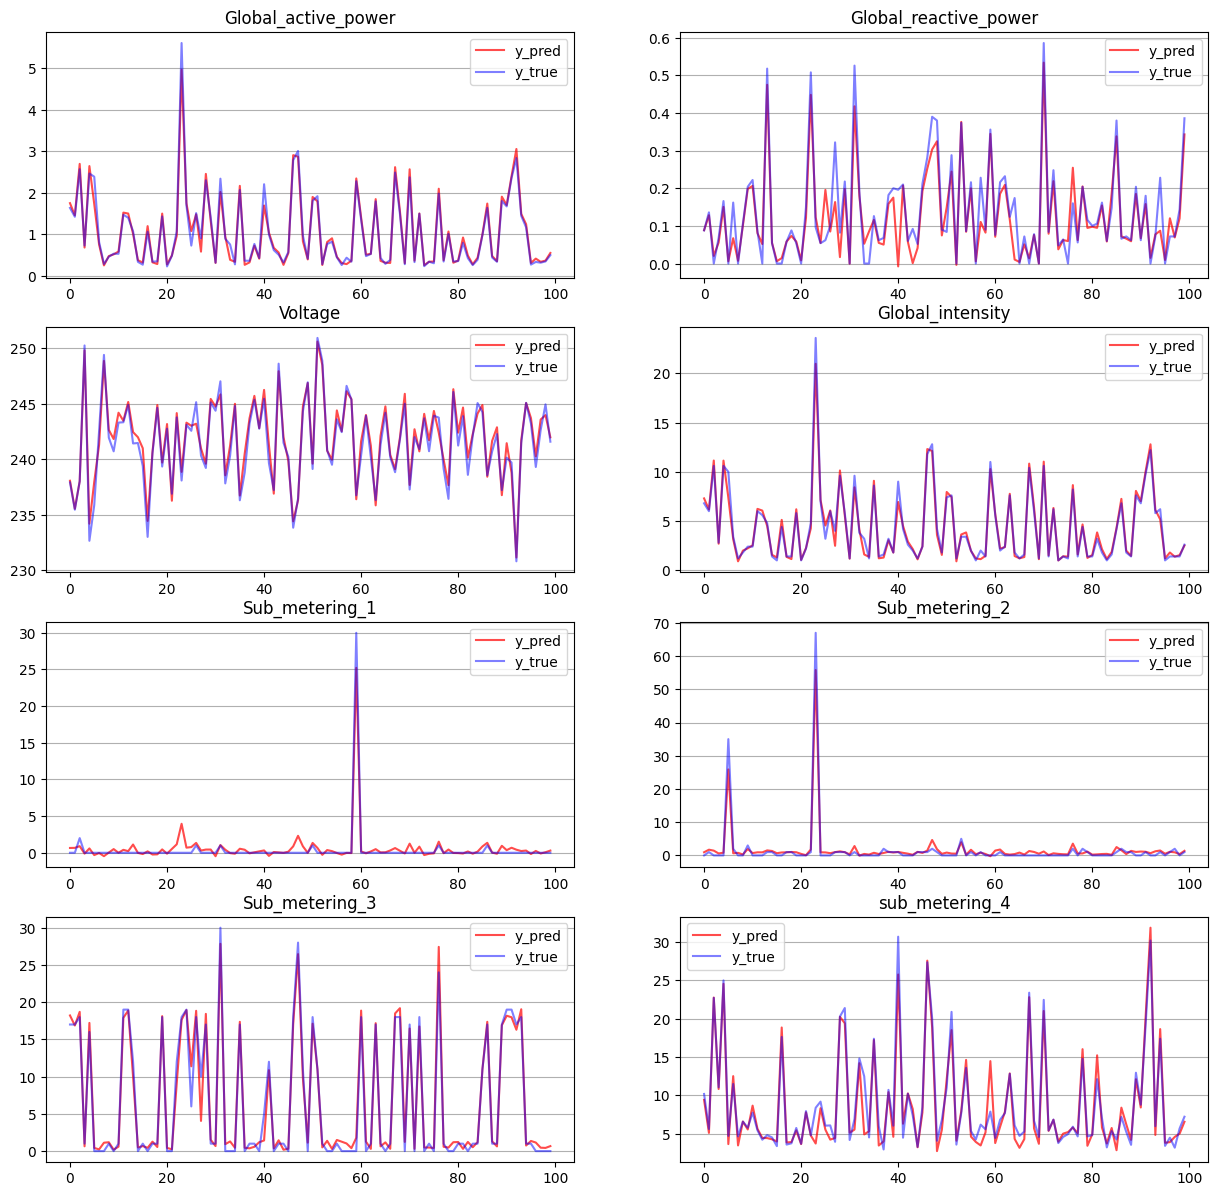

In [27]:
def visualization(y_true, y_pred):
    feture_num = y_true.shape[1]

    plt.figure(figsize=(15, 30))
    for i, col in zip(range(feture_num), df.columns):
        plt.subplot(feture_num, 2, i+1)
        plt.plot(y_pred[:100,i], color='red', alpha=0.7, label='y_pred')
        plt.plot(y_true[:100,i], color='blue', alpha=0.5, label='y_true')
        plt.title(col)
        plt.legend()
        plt.grid(visible=True, axis='y')
    plt.show()

visualization(y_true, y_pred)

## 7. 预测整个序列

试验预测下一个点

In [28]:
# 预测下一个点
start = 2001000
feture_num = data.shape[1]
seq = data[start:start+NUM_STEPS]
seq_reshape = seq.reshape(-1,NUM_STEPS,feture_num)

seq_reshape.shape

(1, 60, 8)

In [29]:
next_elem = model.predict(seq_reshape)
next_elem

1/1 [==============================] - 0s 16ms/step


array([[0.12332611, 0.05023642, 0.4953642 , 0.11967531, 0.00252125,
        0.00811627, 0.593956  , 0.05133882]], dtype=float32)

In [30]:
seq = np.concatenate((seq[1:], next_elem))
seq.shape

(60, 8)

整合成函数

In [31]:
# 基于之前的预测序列往下预测
def predict_sequence(data_slice, num_steps, verbose=1):
    assert len(data_slice) > num_steps, 'len(data_slice) should greater than num_steps'
    feture_num = data_slice.shape[1]
    num_predict = len(data_slice) - num_steps

    # 取第一个num_steps长序列
    pred_list = []
    seq = data_slice[:num_steps]
    for i in range(num_predict):
        seq_reshape = seq.reshape(-1,num_steps,feture_num)
        next_elem = model.predict(seq_reshape, verbose=verbose)
        pred_list.append(next_elem)
        seq = np.concatenate((seq[1:], next_elem))

    return np.array(pred_list).reshape(-1,feture_num)

In [32]:
data_size = 200
dt = data[start:start+data_size]

predict_res = predict_sequence(data_slice=dt,
                               num_steps=NUM_STEPS,
                               verbose=0)
predict_res

array([[0.12332611, 0.05023642, 0.4953642 , ..., 0.00811627, 0.593956  ,
        0.05133882],
       [0.12757903, 0.05659896, 0.5058376 , ..., 0.01499432, 0.5989252 ,
        0.05198476],
       [0.13237694, 0.05946586, 0.5113607 , ..., 0.01935033, 0.6008381 ,
        0.05355043],
       ...,
       [0.01707451, 0.0128397 , 0.8043242 , ..., 0.02419721, 0.09180386,
        0.02453193],
       [0.01684469, 0.01288245, 0.8038308 , ..., 0.02421998, 0.09164242,
        0.02421587],
       [0.01662003, 0.01292065, 0.80335397, ..., 0.02423723, 0.09147849,
        0.02391014]], dtype=float32)

In [33]:
s_pred = np.concatenate((np.array([[None for _ in range(feture_num)] for _ in range(NUM_STEPS)]), predict_res))
s_pred.shape

(200, 8)

In [34]:
dt.shape

(200, 8)

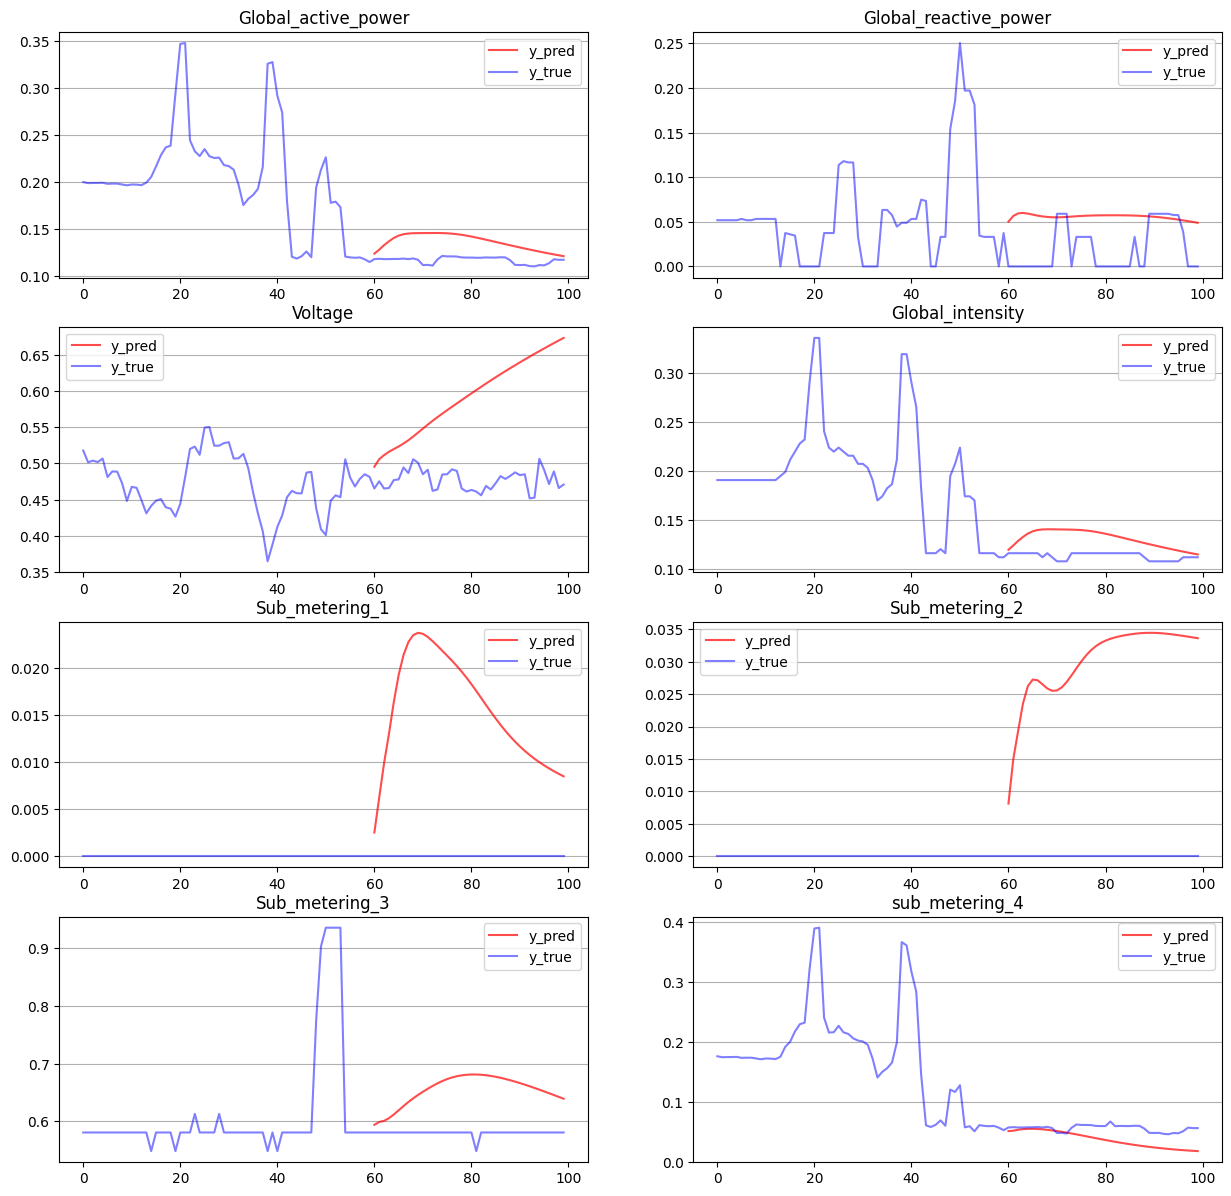

In [35]:
visualization(y_true=dt, y_pred=s_pred)

In [36]:
# 包装成一个方便调用函数
def predict_sequence_wrap(data, start, num_predict, num_steps):
    feture_num = data.shape[1]
    data_size = num_steps + num_predict
    dt = data[start:start+data_size]
    predict_res = predict_sequence(data_slice=dt,
                                   num_steps=num_steps,
                                   verbose=0)
    s_pred = np.concatenate((np.array([[None for _ in range(feture_num)] for _ in range(num_steps)]), predict_res))
    visualization(y_true=dt, y_pred=s_pred)

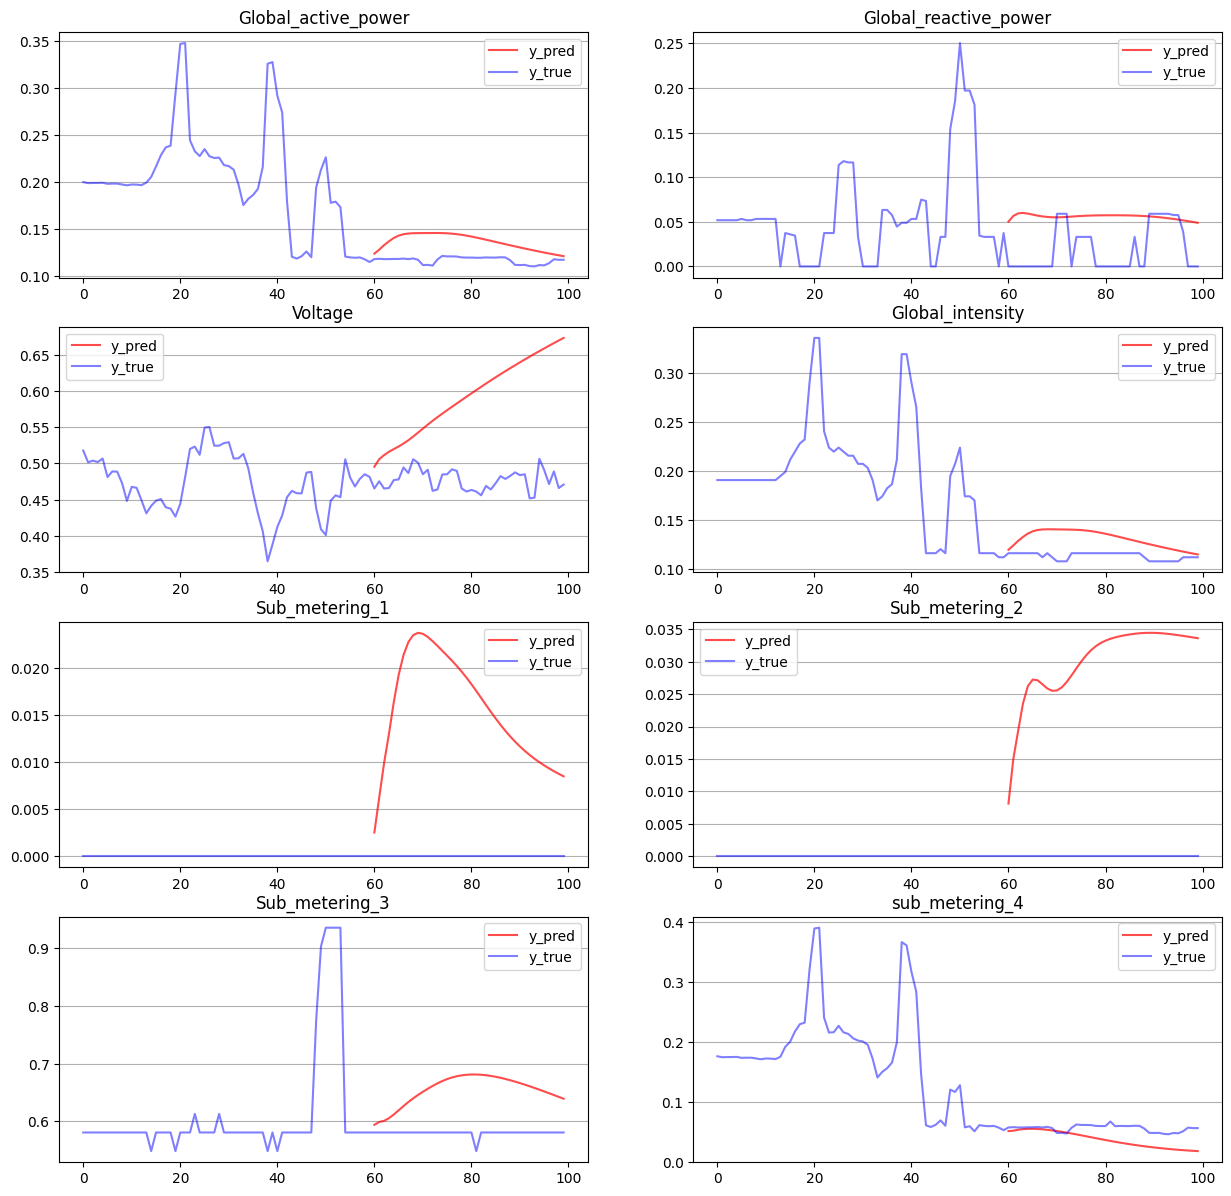

In [37]:
predict_sequence_wrap(data=data,
                      start=2001000,
                      num_predict=265,
                      num_steps=NUM_STEPS)